In [19]:
from lib import *

def fmtDate(y, date, fmt):
    updated_date = datetime.datetime(y, date.month, date.day, date.hour, date.minute)
    return datetime.datetime.strftime(updated_date, fmt)

def todFromDate(date):
    hr = date.hour
    if hr < 6: return 'night'
    elif 6 <= hr < 12: return 'morning'
    elif 12 <= hr < 18: return 'afternoon'
    return 'evening'

BY_LOC_CATS = ['by_minute', 'by_hour', 'by_time_of_day', 'all']

def getCatsAndCons(year, date, min_fmt=minute_format, hr_fmt=hour_format, day_fmt=day_format):
    return [
        ('by_minute', f'''   strftime('{min_fmt}', pickup_datetime)='{fmtDate(year, date, min_fmt)}'    '''),
        ('by_hour', f'''   strftime('{hr_fmt}', pickup_datetime)='{fmtDate(year, date, hr_fmt)}'    '''),
        (
            'by_time_of_day', 
            f''' 
                time_of_day='{todFromDate(date)}' AND 
                strftime('{day_fmt}', pickup_datetime)='{fmtDate(year, date, day_fmt)}'
            '''
        ),
        ('all', None)
    ]

def displayByCat(data):
    O.out(SEPARATOR)
    for c in BY_LOC_CATS:
        O.out(f'Category: {c}')
        O.out(data[c], True, 10)
        O.out(SEPARATOR)

# we want to do predict total_amount
def get_data_by_loc(pu_location_id, do_location_id, date, taxi_type = GREEN):
    cols = [
        'pu_location_id', 'pu_location',
        'do_location_id', 'do_location',
        'pickup_datetime', 'time_of_day', 
        'trip_duration', 'trip_distance',
        'total_amount', 'fare_amount', 
        'tip_amount', 'tolls_amount', 'passenger_count',
        'extra', 'fare_amount','mta_tax',
        'improvement_surcharge','congestion_surcharge',
    ]

    chunks = {}
    for c in BY_LOC_CATS:
        chunks[c] = []

    for y in range(MIN_YEAR, MAX_YEAR+1):
        DR.setTable(y, taxi_type)
        
        for (cat, con) in getCatsAndCons(y, date):
            conditions = [
                f'''CAST(strftime('%Y', pickup_datetime) as integer)={y}''',
                f'''pu_location_id={pu_location_id}''',
                f'''do_location_id={do_location_id}'''
            ]
            if con is not None:
                conditions.append(con)

            sql = f'''
            {selFrom(cols, y, taxi_type)}
            WHERE {' AND '.join(conditions)}
            '''
            chunks[cat].append(getDF(text(sql)))
    
    for k in BY_LOC_CATS:
        chunks[k] = pd.concat(chunks[k], ignore_index=True)
        for intcol in ['trip_duration', 'passenger_count']:
            chunks[k][intcol] = chunks[k][intcol].astype(float)

    return chunks

test_pu = 74
test_do = 75
test_date = datetime.datetime(2023, 10, 27, 13, 5)

green_bc = get_data_by_loc(pu_location_id=test_pu, do_location_id=test_do, date=test_date, taxi_type= GREEN)
yellow_bc = get_data_by_loc(pu_location_id=test_pu, do_location_id=test_do, date=test_date, taxi_type= YELLOW)
# displayByCat(yellow_bc)

In [21]:
def out_sample_tt(train, test, label='', train_page_size=7, test_page_size=3):
    O.out(f'{label} train data: ')
    O.out(train, True, train_page_size)
    O.out(f'{label} test data: ')
    O.out(test, True, test_page_size)

def display_computed_total_amount(data, taxi_type):
    O.out(f'{taxi_type.capitalize()} Taxi total_amount vs computed_total_amount')
    data['computed_total_amount'] = data.apply(lambda row: compute_total_amount(row, taxi_type), axis=1)
    train, test = train_test_split(data, test_size=0.3)
    # out_sample_tt(train, test, 'total_amount')
    actual, computed = data['total_amount'].median(), data['computed_total_amount'].median()
    O.out(f'Actual: {actual}, computed: {computed:.02f} (median)')

LINREG_FEATS = [
    'trip_duration', 'passenger_count',
    'trip_distance', 
    'tip_amount', 'tolls_amount', 'extra', 'fare_amount', 'mta_tax',
    'improvement_surcharge', 'congestion_surcharge',
 ]
LINREG_DEP = 'total_amount'

def display_lin_reg(data, taxi_type):
    O.out(f'{taxi_type.capitalize()} Taxi Actual vs LINEAR REGRESSION Forecast')
    model = LinRegForecast(LINREG_FEATS, LINREG_DEP, data)
    pred, test = model.getPredNTest()
    actual, computed = np.median(pred), np.median(test)
    O.out(f'Actual: {actual:.02f}, computed: {computed:.02f} (median)')
    return 0

def predict_total_amount(green_bc, yellow_bc):
    # make a table of all methods
    O.out(SEPARATOR)
    for c in BY_LOC_CATS:
        O.out('*' * 10)
        O.out(f'Category: {c}')
        O.out('*' * 10)

        green_df = green_bc[c]
        if len(green_df) > 0:
            display_computed_total_amount(green_df, GREEN)
            O.out(SEPARATOR)
            display_lin_reg(green_df, GREEN)
            O.out(SEPARATOR)
            
        yellow_df = yellow_bc[c]
        if len(yellow_df) > 0:
            display_computed_total_amount(yellow_df, YELLOW)
            O.out(SEPARATOR)
            display_lin_reg(yellow_df, YELLOW)
            O.out(SEPARATOR)

# test_pu = 74
# test_do = 75
# test_date = datetime.datetime(2023, 10, 27, 13, 5)

# green_bc = get_data_by_loc(pu_location_id=test_pu, do_location_id=test_do, date=test_date, taxi_type= GREEN)
# yellow_bc = get_data_by_loc(pu_location_id=test_pu, do_location_id=test_do, date=test_date, taxi_type= YELLOW)

O.out(f'Pickup Location: {test_pu}, Dropoff Location: {test_do}, time: {test_date}')

# predict_total_amount(green_bc, yellow_bc)
# predict_total_amount(green_df)


In [ ]:
# from lib import *

# def getDataByLoc(pu_location_id, do_location_id, taxi_type = GREEN):
#     # date_str = datetime.datetime.strftime(date, day_format)
#     chunks = []

#     cols = [
#         'pu_location_id', 'pu_location',
#         'do_location_id', 'do_location',
#         'COUNT(1) as trip_count'
#         # 'time_of_day',
#         # 'trip_duration',
#         # 'f_total_amount', 'f_fare_amount', 'tip_amount', 'tolls_amount'
#     ]

#     for y in range(MIN_YEAR, MAX_YEAR+1):
#         DR.setTable(y, taxi_type)

#         sql = f'''
#     {selFrom(cols, y, taxi_type)}
#     WHERE CAST(strftime('%Y', pickup_datetime) as integer)={y}
#     GROUP BY {cols[0]}, {cols[2]}
#     ORDER BY trip_count DESC

# '''
#         # WHERE pu_location_id={pu} AND do_location_id={do}
#         # AND strftime('{day_format}', pickup_datetime)='{date_str}'
#         chunks.append(getDF(text(sql)))
#     df = pd.concat(chunks, ignore_index=True)
#     df = df.groupby(['pu_location_id', 
#                      'do_location_id']).agg({'trip_count':'sum', 
#                                              'do_location': 'first', 
#                                              'pu_location':'first'}).sort_values(['trip_count'],ascending=False)
#     return df

# def printGreenVsYellowTripsByLocation():
#     green_df = getDataByLoc(GREEN)
#     yellow_df = getDataByLoc(YELLOW)
#     # O.out(df, True, 100)
#     df = pd.merge(green_df, yellow_df, how='inner', on=['pu_location_id', 
#                                                         'do_location_id'], suffixes=['_green', 
#                                                                                     '_yellow']).sort_values(['trip_count_green',
#                                                                                                             'trip_count_yellow'], ascending=False)

#     O.out('Locations to compare Green & Yellow Taxi trips...')
#     O.out(df, True, 100)

# # printGreenVsYellowTripsByLocation()

In [9]:
from lib import *

year = 2021
taxi_type = YELLOW

DR.setTable(year, taxi_type)
table_name = DR.getTableName()
u_table_name = DR.getTableName('uniq_')

pu = 41
do = 1

sql = f"""
select f_total_amount, f_fare_amount, 
    cast(strftime('%H', pickup_datetime) as integer) as hour,
    (unixepoch(dropoff_datetime)-unixepoch(pickup_datetime)) as trip_duration
 from {u_table_name} 
 where (strftime('%Y', pickup_datetime))='{year}' and
    trip_duration > 0 AND trip_duration <= 7200 and
    pu_location_id={pu} and do_location_id={do} 
    
"""
# and hour > 6 and hour < 18

# sql = f"""
# select *,
#     (unixepoch(dropoff_datetime)-unixepoch(pickup_datetime)) as trip_duration
#  from {u_table_name} 
#  where (strftime('%Y', pickup_datetime))='{year}' and
#     trip_duration > 0 AND trip_duration <= 7200
# """

# sql = f"""
# select location_name, zone, location_id from taxi_zones
# where location_name='EWR'
# """

df = getDF(text(sql))
O.out(df, True, 20)

In [4]:
# total_amount, tip_amount, toll_amount by pu_location_id, do_location_id and time of day (m-a-e-n)
from lib import *

year = 2023
taxi_type = GREEN

DR.setTable(year, taxi_type)
table_name = DR.getTableName()
u_table_name = DR.getTableName('uniq_')

# SELECT  CAST(strftime('%H', pickup_datetime) as integer) as time_of_day, 
#     count(1) as Count
# FROM {u_table_name} 
# GROUP BY time_of_day
# LIMIT 100

sql = f"""
SELECT 
    (SELECT (location_name || ", " || zone) FROM taxi_zones WHERE location_id=pu_location_id) as pu_location, 
    (SELECT (location_name || ", " || zone) FROM taxi_zones WHERE location_id=do_location_id) as do_location, 
    CASE  
        WHEN CAST(strftime('%H', pickup_datetime) as integer) < 6
            THEN 'night' 
        WHEN CAST(strftime('%H', pickup_datetime) as integer) >= 6 AND CAST(strftime('%H', pickup_datetime) as integer) < 12
            THEN 'morning'
        WHEN CAST(strftime('%H', pickup_datetime) as integer) >= 12 AND CAST(strftime('%H', pickup_datetime) as integer) < 18
            THEN 'afternoon'
        ELSE 'evening' 
    END time_of_day,
    AVG(f_total_amount) as total_amount,
    AVG(f_fare_amount) as fare_amount,
    AVG(tip_amount) as tip_amount,
    AVG(tolls_amount) as tolls_amount,
    COUNT(1) as trip_count
    
FROM {u_table_name} 
GROUP BY pu_location_id, do_location_id, time_of_day
ORDER BY trip_count DESC
"""
O.clear()
O.out(f'Test - {datetime.datetime.now()}')
O.out(f'time_of_day - 0 - night, 1 - morning, 2 - afternoon, 3 - evening')
O.out(getDF(text(sql)), True, 30)
# runSql


sql engine ready


In [ ]:
# import calendar
# from tabulate import tabulate

# def print_calendar_month(year, month):
#     """Prints a calendar month using tabulate."""

#     # Get the calendar for the given month
#     cal = calendar.monthcalendar(year, month)

#     # Create a list of weekdays for the header
#     weekdays = ["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"]

#     # Create a table for the calendar
#     table = [weekdays] + cal

#     # Print the calendar using tabulate
#     print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# # Example usage
# year = 2024
# month = 10
# print_calendar_month(year, month)

In [ ]:
# import calendar
# from datetime import date
# from tabulate import tabulate

# data = {
#     'pickup_datetime': pd.date_range(start='2024-01-01', periods=500, freq='D'),
#     'total_amount': np.random.randint(10, 50, size=500)
# }
# df = pd.DataFrame(data)

# weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# def mapDataToCal(year, month, data, feature = 'total_amount'):
#     cal = calendar.monthcalendar(year, month)
#     # print(cal)
#     res = []
#     for i in range(len(cal)):
#         row = []
#         res.append(row)
#         for j in range(len(cal[i])):
#             # print(f'abs_count: {val}, date: {cal[i][j]}, day: {weekdays[j]}')
#             day = cal[i][j]
#             if day > 0:
#                 df_day = data[data['pickup_datetime'] == f'{year}-{month:02d}-{day:02d}']
#                 day_ta = df_day[feature].iloc[0]
#                 str = f"""{day}
# {feature}: {day_ta}"""
#                 row.append(str)
#             else:
#                 row.append('-')

#     return res


# table = [weekdays] + mapDataToCal(2024, 10, df)

#     # Print the calendar using tabulate
# print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# # print(data["pickup_datetime"])

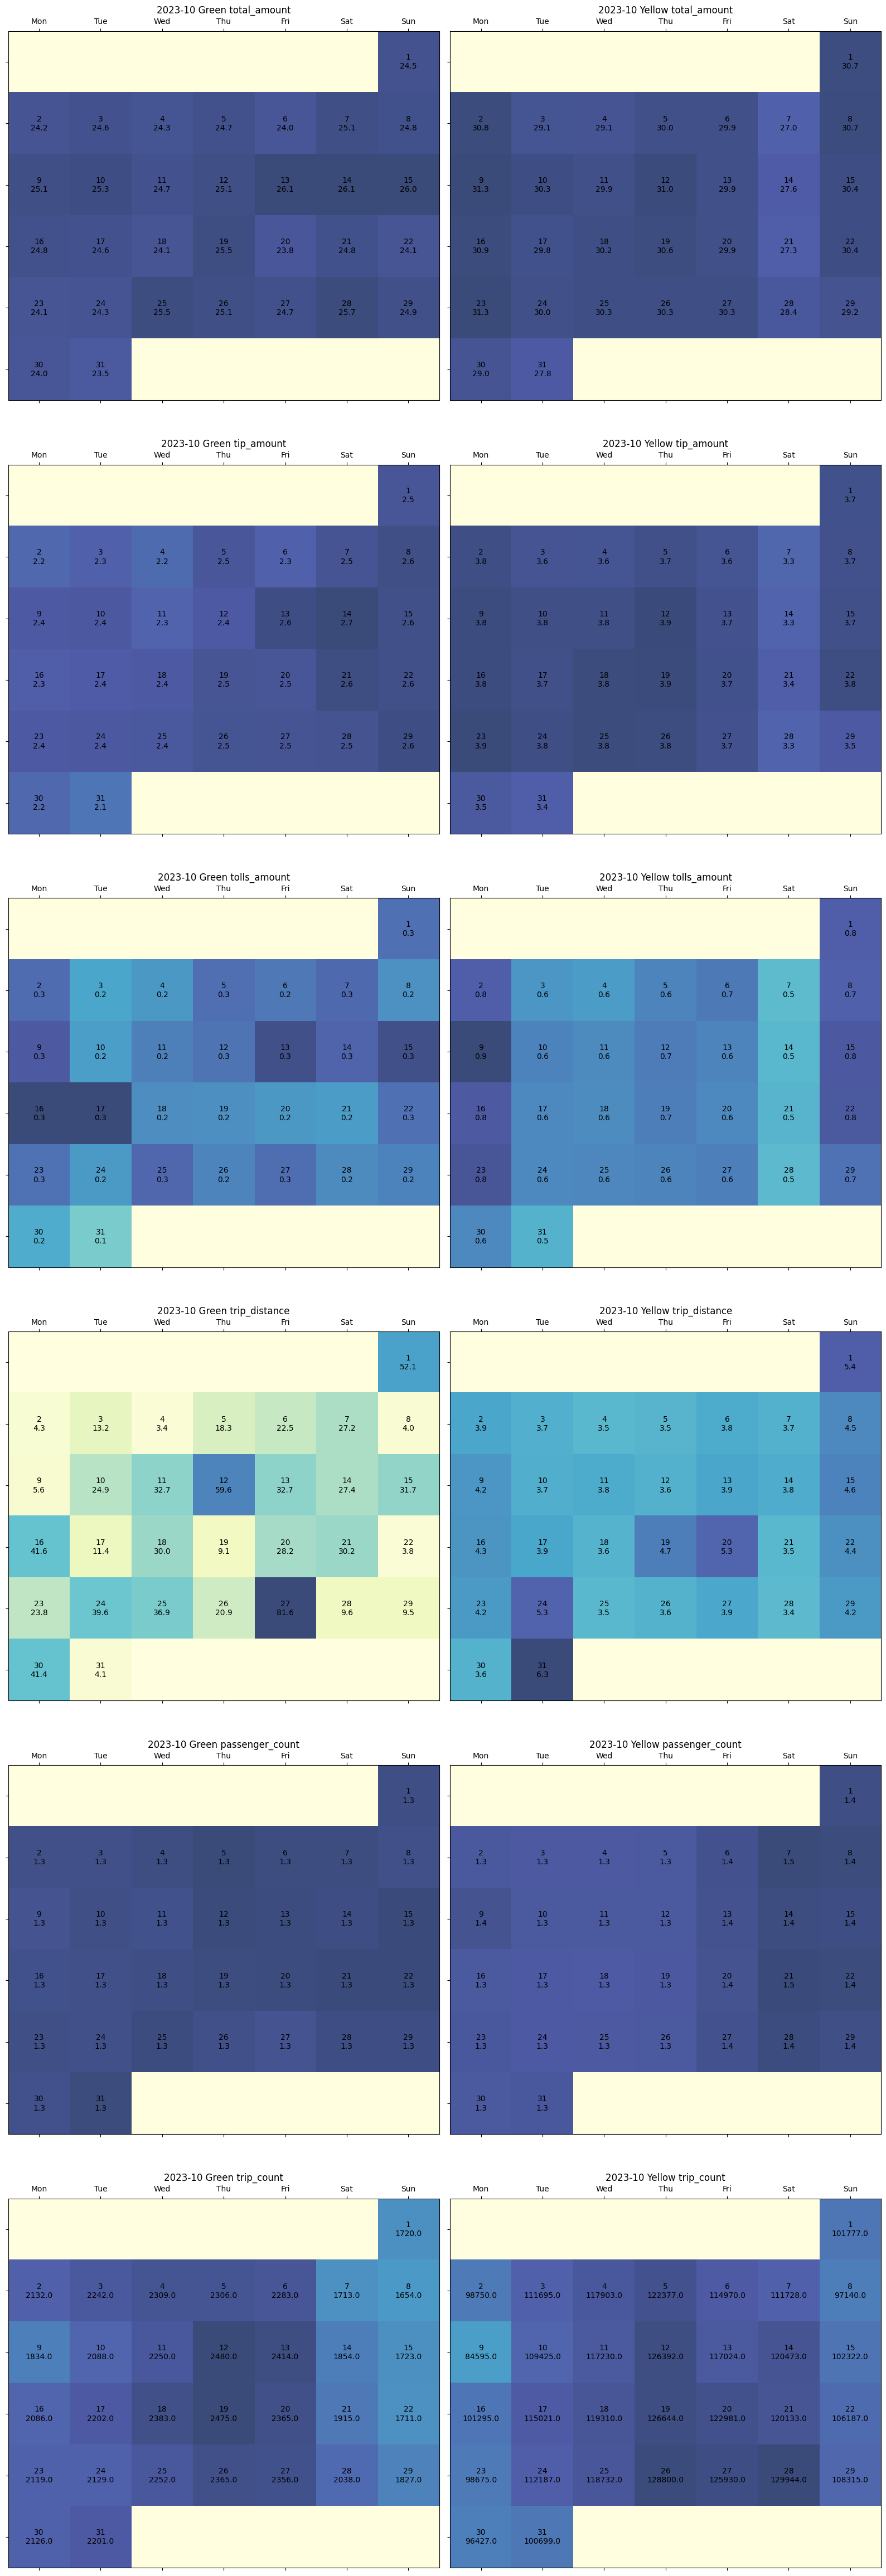

In [2]:
def filterByDate(data, year, month, day):
    return data[data['date'] == f'{year}-{month:02d}-{day:02d}']

def getSql(table_name):
    return text(f'''
SELECT strftime('%Y-%m-%d', pickup_datetime) as date, 
    AVG(f_total_amount) as total_amount,
    AVG(tip_amount) as tip_amount,
    AVG(tolls_amount) as tolls_amount,
    AVG(f_trip_distance) as trip_distance,
    AVG(f_passenger_count) as passenger_count,
    COUNT(1) as trip_count                    
FROM {table_name}
WHERE f_total_amount > 0 AND 
    f_trip_distance > 0 AND 
    f_passenger_count > 0
GROUP BY date
ORDER BY date
''')

weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
def mapDataToCal(year, month, data, feature = 'total_amount'):
    cal = calendar.monthcalendar(year, month)
    # print(cal)
    res = []
    for i in range(len(cal)):
        row = []
        res.append(row)
        for j in range(len(cal[i])):
            day = cal[i][j]
            if day > 0:
                # df_day = data[data['pickup_datetime'] == f'{year}-{month:02d}-{day:02d}']
                df_day = filterByDate(data, year, month, day)
                row.append(df_day[feature].iloc[0])
            else:
                row.append(0)

    return res

# total_amount, tip_amount, tolls_amount, trip_distance, passenger_count, trip_count
def plotCalHeatMap(year, month):

    taxis = [GREEN, YELLOW]
    features = [
        'total_amount', 'tip_amount', 'tolls_amount', 
        'trip_distance', 'passenger_count', 'trip_count'
        ]
    fig, axs = plt.subplots(len(features), len(taxis), figsize=(16, 8*len(features)))
    # print(axs.shape)
    for tn, taxi_type in enumerate(taxis):
        DR.setTable(year, taxi_type)
        # table_name = DR.getTableName('uniq_')
        table_name = DR.getTableName()
        df = getDF(getSql(table_name))
    
        for fn, feature in enumerate(features):
            cal_data = mapDataToCal(year, month, df, feature)
            if len(features) > 1:
                # print(fn, tn)
                ax = axs[fn, tn]
            else:
                ax = axs[tn]

            # Plot the calendar heatmap using matplotlib
            # fig, ax = plt.subplots(figsize=(10, 6))
            cax = ax.matshow(cal_data, 
                             cmap='YlGnBu', 
                             alpha=0.8)

            # Add day labels to the heatmap
            for i in range(len(cal_data)):
                for j in range(7):
                    day = i * 7 + j + 1 - calendar.monthrange(year, month)[0]  # Offset for the first day of the month
                    if 1 <= day <= 31:
                        df_day = filterByDate(df, year, month, day)
                        ax.text(j, i, f'{day}\n{df_day[feature].iloc[0]:.1f}', va='center', ha='center')

            # Set the day of the week labels
            ax.set_xticks(np.arange(7))
            ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

            # Set the week labels (empty because weeks are dynamic)
            ax.set_yticks(np.arange(len(cal_data)))
            ax.set_yticklabels(['']*len(cal_data))

            # Add color bar
            # fig.colorbar(cax)

            # Set the title
            ax.set_title(f'{year}-{month:02d} {taxi_type.capitalize()} {feature}')
            plt.tight_layout()

    # plt.title(f'{year}-{month:02d} {taxi_type.capitalize()} {feature}')
    plt.show()

plotCalHeatMap(2023, 10)


In [ ]:
# # ***
# # plot monthly data green vs yellow
# # ***
# def filterByDate(data, year, month, day):
#     return data[data['date'] == f'{year}-{month:02d}-{day:02d}']

# def getSql(table_name):
#     return text(f'''
# SELECT strftime('%Y-%m-%d', pickup_datetime) as date, 
#     AVG(f_total_amount) as total_amount,
#     AVG(tip_amount) as tip_amount,
#     AVG(tolls_amount) as tolls_amount,
#     AVG(f_trip_distance) as trip_distance,
#     AVG(f_passenger_count) as passenger_count,
#     COUNT(1) as trip_count                    
# FROM {table_name}
# WHERE f_total_amount > 0 AND 
#     f_trip_distance > 0 AND 
#     f_passenger_count > 0
# GROUP BY date
# ORDER BY date
# ''')

# weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# def mapDataToCal(year, month, data, feature = 'total_amount'):
#     cal = calendar.monthcalendar(year, month)
#     # print(cal)
#     res = []
#     for i in range(len(cal)):
#         row = []
#         res.append(row)
#         for j in range(len(cal[i])):
#             day = cal[i][j]
#             if day > 0:
#                 # df_day = data[data['pickup_datetime'] == f'{year}-{month:02d}-{day:02d}']
#                 df_day = filterByDate(data, year, month, day)
#                 row.append(df_day[feature].iloc[0])
#             else:
#                 row.append(0)

#     return res

# # total_amount, tip_amount, tolls_amount, trip_distance, passenger_count, trip_count
# def plotCalHeatMap(year, month):

#     taxis = [GREEN, YELLOW]
#     features = [
#         'total_amount', 'tip_amount', 'tolls_amount', 
#         'trip_distance', 'passenger_count', 'trip_count'
#         ]
#     fig, axs = plt.subplots(len(features), len(taxis), figsize=(16, 8*len(features)))
#     # print(axs.shape)
#     for tn, taxi_type in enumerate(taxis):
#         DR.setTable(year, taxi_type)
#         # table_name = DR.getTableName('uniq_')
#         table_name = DR.getTableName()
#         df = getDF(getSql(table_name))
    
#         for fn, feature in enumerate(features):
#             cal_data = mapDataToCal(year, month, df, feature)
#             if len(features) > 1:
#                 # print(fn, tn)
#                 ax = axs[fn, tn]
#             else:
#                 ax = axs[tn]

#             # Plot the calendar heatmap using matplotlib
#             # fig, ax = plt.subplots(figsize=(10, 6))
#             cax = ax.matshow(cal_data, 
#                              cmap='YlGnBu', 
#                              alpha=0.8)

#             # Add day labels to the heatmap
#             for i in range(len(cal_data)):
#                 for j in range(7):
#                     day = i * 7 + j + 1 - calendar.monthrange(year, month)[0]  # Offset for the first day of the month
#                     if 1 <= day <= 31:
#                         df_day = filterByDate(df, year, month, day)
#                         ax.text(j, i, f'{day}\n{df_day[feature].iloc[0]:.1f}', va='center', ha='center')

#             # Set the day of the week labels
#             ax.set_xticks(np.arange(7))
#             ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

#             # Set the week labels (empty because weeks are dynamic)
#             ax.set_yticks(np.arange(len(cal_data)))
#             ax.set_yticklabels(['']*len(cal_data))

#             # Add color bar
#             # fig.colorbar(cax)

#             # Set the title
#             ax.set_title(f'{year}-{month:02d} {taxi_type.capitalize()} {feature}')
#             plt.tight_layout()

#     # plt.title(f'{year}-{month:02d} {taxi_type.capitalize()} {feature}')
#     plt.show()

# plotCalHeatMap(2023, 10)


In [2]:
# # ctables = [
# #     (GREEN, 2023), 
# #     (YELLOW, 2023)
# # ]

# for t in TABLES:
# # for t in ctables:
#     taxi_type, year  = t
#     DR.setTable(year, taxi_type)
#     table_name = DR.getTableName()
#     O.out(f'table: {table_name}')
#     uniq_table_name = DR.getTableName('uniq_')

#     # of trips by month
#     sql = text(f'''
#     SELECT COUNT(1) as num_trips, (strftime('%Y-%m', pickup_datetime)) as month 
#     FROM {uniq_table_name}
#     WHERE CAST(strftime('%Y', pickup_datetime) AS integer)={year}
#     GROUP BY month
#     ORDER BY num_trips DESC
# ''')
#     df = getDF(sql)
#     O.out(df, True)

#     O.out(SEPARATOR)

In [15]:
# # deleting outliers - rows where location ids are not present in taxi zones
# # pu_location_id', 'do_location_id
# # pickup_datetime', 'dropoff_datetime
# def getSqls(table_name):
#     return [
#         ('Deleted rows with invalid location ids: ', f'DELETE FROM {table_name} WHERE pu_location_id NOT IN (SELECT location_id FROM taxi_zones) OR do_location_id NOT IN (SELECT location_id FROM taxi_zones)'),
#         ('Deleted rows with trip duration is negative, zero or > 8000 seconds: ', f'DELETE FROM {table_name} WHERE pickup_datetime >= dropoff_datetime OR (unixepoch(dropoff_datetime)-unixepoch(pickup_datetime)) > 8000'),
#         ('Deleted rows with trip distance > 20 miles: ', f'DELETE FROM {table_name} WHERE f_trip_distance > 20'),
#         ('Deleted rows with total amount > 100 USD: ', f'DELETE FROM {table_name} WHERE f_total_amount > 100'),
#     ]

# for t in TABLES:
#     taxi_type, year  = t
#     DR.setTable(year, taxi_type)
#     table_name = DR.getTableName()
#     O.out(f'table: {table_name}')
#     uniq_table_name = DR.getTableName('uniq_')

#     queries = getSqls(uniq_table_name)
#     for (m, sql) in queries:
#         res = runSql(text(sql), True)
#         O.out(f'{m} {res.rowcount}')

#     O.out(SEPARATOR)





In [4]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plotNegPos(categories, values):
#     # Width of each bar
#     width = 0.35

#     # Create an array of x positions for the bars
#     x = np.arange(len(categories))

#     # Create the figure and axes
#     fig, ax = plt.subplots()
#     fig.set_figwidth(16)
#     fig.set_figheight(9)

#     # Plot the first set of bars
#     rects1 = ax.bar(x - width/2, values['neg'], width, label='Negative')

#     # Plot the second set of bars
#     rects2 = ax.bar(x + width/2, values['pos'], width, label='Positive')

#     # Add labels and titles
#     ax.set_xticks(x)
#     ax.set_xticklabels(categories)
#     ax.set_ylabel('Values')
#     ax.set_title('Positive vs Negative Values')
#     ax.legend()

#     # Show the plot
#     plt.show()

In [ ]:
# # ctables = [(GREEN, 2023)]

# numericals = [
#     'passenger_count', 'trip_distance', 'total_amount',
#     'fare_amount', 'tip_amount', 'mta_tax', 'tolls_amount', 'extra', 'improvement_surcharge', 'congestion_surcharge',
# ]

# def posClause():
#     conditions = []
#     for i,c in enumerate(numericals):
#         if (i+1) % 4 == 0:
#             conditions.append(f'\n\t\t{c} >= 0')
#         else:
#             conditions.append(f'{c} >= 0')
#     return " AND ".join(conditions)

# def negClause():
#     conditions = []
#     for i,c in enumerate(numericals):
#         if (i+1) % 4 == 0:
#             conditions.append(f'\n\t\t{c} < 0')
#         else:
#             conditions.append(f'{c} < 0')
#     return " OR ".join(conditions)

# cats = {'green': [], 'yellow': []}
# vals = {'green': {'neg': [], 'pos': []}, 'yellow': {'neg': [], 'pos': []}}

# for t in TABLES:
#     taxi_type, year  = t
#     DR.setTable(year, taxi_type)
#     table_name = DR.getTableName()
#     O.out(f'table name: {table_name}')

#     O.out(f'Negative values analysis')
#     O.out(SEPARATOR)
    
#     sql = text(f'''
#     SELECT 
#         (SELECT COUNT(1) FROM {table_name} WHERE {posClause()}) as pos,
#         (SELECT COUNT(1) FROM {table_name} WHERE {negClause()}) as neg
# ''')
#     # print(sql)
#     O.out(sql)
#     df = getDF(sql)
#     O.out(df, True)

#     cats[taxi_type].append(f'{year}-{taxi_type}')
#     vals[taxi_type]['neg'].append(df['neg'].iloc[0])
#     vals[taxi_type]['pos'].append(df['pos'].iloc[0])

# plotNegPos(cats[GREEN], vals[GREEN])
# plotNegPos(cats[YELLOW], vals[YELLOW])



In [13]:
# for t in TABLES:
#     taxi_type, year  = t
#     DR.setTable(year, taxi_type)
#     table_name = DR.getTableName()

#     res = runSql(text(f'''
#     SELECT COUNT(1) FROM {table_name}
# '''))

#     O.out(f'table name: {table_name}')
#     O.out(f'# of rows: {res.scalar()}')
#     O.out(SEPARATOR)

In [10]:
# # count zero and negative values

# numericals = [
#     'passenger_count', 'trip_distance', 'total_amount',
#     'fare_amount', 'tip_amount', 'mta_tax', 'tolls_amount', 'extra', 'improvement_surcharge', 'congestion_surcharge',
# ]

# for t in TABLES:
#     taxi_type, year  = t
#     DR.setTable(year, taxi_type)
#     table_name = DR.getTableName()
#     zeroresults = []
#     negresults = []
#     O.out(f'table name: {table_name}')

#     for col in numericals:

#         res = runSql(text(f'''
#     SELECT COUNT(1) FROM {table_name} WHERE {col}=0
# '''))
#         # O.out(f'#rows where {col}=0: {res.scalar()}')
#         zeroresults.append(res.scalar())

#         res = runSql(text(f'''
#     SELECT COUNT(1) FROM {table_name} WHERE {col}<0
# '''))
#         negresults.append(res.scalar())

#     O.out(tabulate({'Columns': numericals, 'Negative': negresults, 'Zero': zeroresults}, headers=['Columns', 'Negative', 'Zero']))
#     O.out(SEPARATOR)

In [11]:
# # delete negative negative

# numericals = [
#     'passenger_count', 'trip_distance', 'total_amount',
#     'fare_amount', 'tip_amount', 'mta_tax', 'tolls_amount', 'extra', 'improvement_surcharge', 'congestion_surcharge',
# ]

# for t in TABLES:
#     taxi_type, year  = t
#     DR.setTable(year, taxi_type)
#     table_name = DR.getTableName()
#     uniq_table_name = DR.getTableName('uniq_')
#     negresults = []
#     delresults = []
#     O.out(f'table name: {table_name}')
#     deleted_count = 0
#     for col in numericals:  
#         sql = text(f'''
#     DELETE FROM {uniq_table_name} WHERE {col}<0
# ''')
#         delres = runSql(sql, commit=True)
#         deleted_count += delres.rowcount
    
#     O.out(f'Total Number of rows with negative values deleted: {deleted_count}')
#     O.out(SEPARATOR)

In [10]:
# # Delete duplicates

# # use COLUMNS
# # def getClause(table_name):
# #     conditions = []
# #     for c in COLUMNS:
# #         conditions.append(f'{table_name}.{c} = t2.{c}')
# #     return " AND ".join(conditions)

# for t in TABLES:
#     taxi_type, year  = t
#     DR.setTable(year, taxi_type)
#     table_name = DR.getTableName()
#     O.out(f'table name: {table_name}')

#     sql = text(f'''
#         DELETE FROM {table_name}
#         WHERE ROWID NOT IN (
#             SELECT MIN(ROWID)
#             FROM green_taxi_trips2020
#             GROUP BY {', '.join(COLUMNS)}
#         );
#     ''')
#     # res = runSql(sql)
#     O.out(sql)
    
#     O.out(f'Total Number of rows with duplicate values deleted: {res.rowcount}')
#     O.out(SEPARATOR)



In [7]:
# # Delete duplicates ALT ALT ALT

# # ctables = [(GREEN, 2023)]

# for t in TABLES:
# # for t in ctables:
#     taxi_type, year  = t
#     DR.setTable(year, taxi_type)
#     table_name = DR.getTableName()
#     uniq_table_name = DR.getTableName('uniq_')
#     O.out(f'table name: {table_name}')

#     sql = text(f'''
#     CREATE TABLE IF NOT EXISTS {uniq_table_name} AS SELECT DISTINCT {', '.join(ALL_COLUMNS)} FROM {table_name};
#     ''')
#     res = runSql(sql, commit=True)
#     O.out(sql)
    
#     O.out(f'Total Number of rows with duplicate values deleted: {res.rowcount}')
#     O.out(SEPARATOR)



In [10]:
# # Delete duplicates verification ALT ALT ALT

# # ctables = [(GREEN, 2023)]

# for t in TABLES:
# # for t in ctables:
#     taxi_type, year  = t
#     DR.setTable(year, taxi_type)
#     table_name = DR.getTableName()
#     uniq_table_name = DR.getTableName('uniq_')
#     O.out(f'table name: {table_name}')

#     sql = text(f'''
#     SELECT COUNT(1) FROM {table_name};
#     ''')
#     # O.out(sql)
#     ogres = runSql(sql)
    
#     sql = text(f'''
#     SELECT COUNT(1) FROM {uniq_table_name};
#     ''')
#     # O.out(sql)
#     uniqres = runSql(sql)
    
#     # O.out(f'# of original rows: {ogres.scalar()}, uniq rows: {uniqres.scalar()}')
#     O.out(f'Total Number of rows with duplicate values deleted: {ogres.scalar() - uniqres.scalar()}')

In [8]:
# # Delete duplicates cleanup ALT ALT ALT

# # ctables = [(GREEN, 2023),(YELLOW, 2023)]

# for t in TABLES:
#     taxi_type, year  = t
#     DR.setTable(year, taxi_type)
#     # table_name = DR.getTableName()
#     uniq_table_name = DR.getTableName('uniq_')
#     O.out(f'table name: {uniq_table_name}')

#     sql = text(f'''
#     DROP TABLE IF EXISTS {uniq_table_name};
#     ''')
#     O.out(sql)
#     res = runSql(sql, commit=True)

#     # O.out(f'# {uniq_table_name}: {res.scalar()}')

In [11]:
# with DR.engn.connect() as conn:
#     # conn.rollback()
#     conn.commit()

In [ ]:
# import pandas as pd
# import numpy as np
# from scipy import stats

# # Example data
# data = {'amount': [10, 12, 15, 13, 10, 12, 1000, 14, 12, 11, 1001]}
# df = pd.DataFrame(data)

# # Calculate the Z-scores for the 'amount' column
# df['z_score'] = stats.zscore(df['amount'])

# # Set a threshold (commonly 3)
# threshold = 3

# # Identify outliers: rows where the absolute Z-score is greater than the threshold
# outliers = df[np.abs(df['z_score']) > threshold]

# # Display outliers
# print("Outliers based on Z-score:")
# print(df)
